In [5]:
!pip install wandb

In [7]:
import wandb
wandb.login()
wandb.login(key="acdc26d2fc17a56e83ea3ae6c10e496128dee648")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: viinod9 (viinod9-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/vinodkumar/.netrc


True

### Question -2 

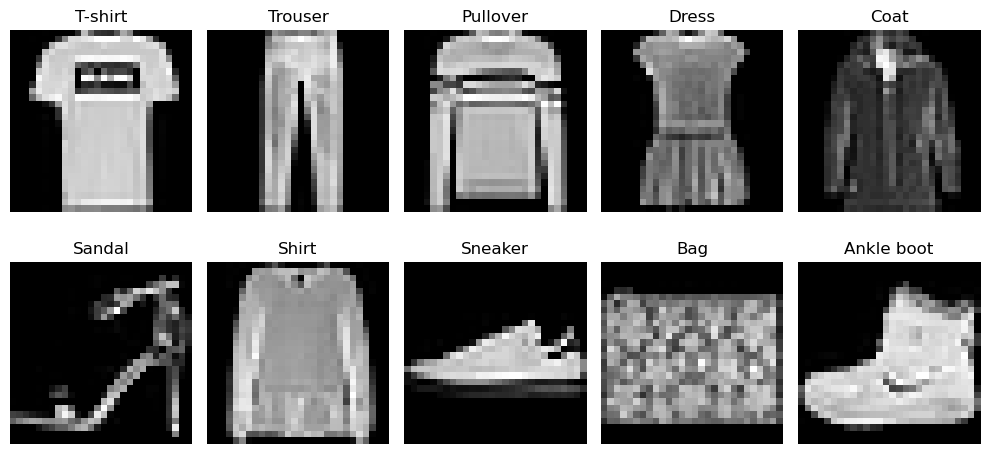

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
from keras.datasets import fashion_mnist

# Initialize wandb
wandb.init(project="fashion-mnist-assignment", name="Question1")

# Load the dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Class labels in Fashion-MNIST
class_labels = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat", 
                "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Find one example for each class
unique_classes = np.unique(y_train)
sample_images = [x_train[np.where(y_train == cls)[0][0]] for cls in unique_classes]

# Log images to wandb
wandb_images = []
for i, img in enumerate(sample_images):
    wandb_images.append(wandb.Image(img, caption=class_labels[i]))

wandb.log({"Fashion-MNIST Samples": wandb_images})

# Plot images in a grid
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i], cmap="gray")
    ax.set_title(class_labels[i])
    ax.axis("off")

plt.tight_layout()
plt.show()

# Finish wandb run
wandb.finish()

In [27]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist

# Initialize wandb
wandb.init(project="fashion-mnist-assignment", name="Question2")

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize and flatten input images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0  # (60000, 784)
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0      # (10000, 784)

# One-hot encode labels
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

# Initialize parameters for 1 hidden layer
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    parameters = {
        "W1": np.random.randn(hidden_size, input_size) * 0.01,
        "b1": np.zeros((hidden_size, 1)),
        "W2": np.random.randn(output_size, hidden_size) * 0.01,
        "b2": np.zeros((output_size, 1)),
    }
    return parameters

# Activation functions
def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))  # Stability trick
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

# Forward propagation
def forward_propagation(X, parameters):
    A0 = X.T  # Input layer
    Z1 = np.dot(parameters["W1"], A0) + parameters["b1"]
    A1 = sigmoid(Z1)  # Hidden layer activation
    Z2 = np.dot(parameters["W2"], A1) + parameters["b2"]
    A2 = softmax(Z2)  # Output layer activation
    
    activations = {"A0": A0, "Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return activations

# Compute loss (cross-entropy)
def compute_loss(Y, Y_hat):
    m = Y.shape[0]
    loss = -np.sum(Y.T * np.log(Y_hat + 1e-9)) / m
    return loss

# Backpropagation
def backward_propagation(X, Y, parameters, activations, learning_rate=0.01):
    m = X.shape[0]
    dZ2 = activations["A2"] - Y.T
    dW2 = np.dot(dZ2, activations["A1"].T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    dA1 = np.dot(parameters["W2"].T, dZ2)
    dZ1 = dA1 * (activations["A1"] * (1 - activations["A1"]))  # Sigmoid derivative
    dW1 = np.dot(dZ1, activations["A0"].T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    # Update parameters
    parameters["W1"] -= learning_rate * dW1
    parameters["b1"] -= learning_rate * db1
    parameters["W2"] -= learning_rate * dW2
    parameters["b2"] -= learning_rate * db2

    return parameters

# Train function
def train_nn(X, Y, input_size, hidden_size, output_size, epochs=100, learning_rate=0.01):
    parameters = initialize_parameters(input_size, hidden_size, output_size)
    
    for epoch in range(epochs):
        activations = forward_propagation(X, parameters)
        loss = compute_loss(Y, activations["A2"])
        parameters = backward_propagation(X, Y, parameters, activations, learning_rate)

        # Log loss to wandb
        wandb.log({"Epoch": epoch, "Loss": loss})
        
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return parameters

# Prediction function
def predict(X, parameters):
    activations = forward_propagation(X, parameters)
    predictions = np.argmax(activations["A2"], axis=0)
    return predictions

# Define network structure
input_size = 784  # 28x28 images
hidden_size = 128  # 1 hidden layer with 128 neurons
output_size = 10   # 10 classes

# Train model
parameters = train_nn(x_train, y_train, input_size, hidden_size, output_size, epochs=100, learning_rate=0.01)

# Evaluate on test data
y_pred = predict(x_test, parameters)
y_true = np.argmax(y_test, axis=1)
accuracy = np.mean(y_pred == y_true)

# Log test accuracy
wandb.log({"Test Accuracy": accuracy})
print(f"Test Accuracy: {accuracy:.4f}")

# Finish wandb run
wandb.finish()

Epoch 0, Loss: 2.3030
Epoch 10, Loss: 2.3021
Epoch 20, Loss: 2.3015
Epoch 30, Loss: 2.3010
Epoch 40, Loss: 2.3005
Epoch 50, Loss: 2.3000
Epoch 60, Loss: 2.2995
Epoch 70, Loss: 2.2991
Epoch 80, Loss: 2.2986
Epoch 90, Loss: 2.2982
Test Accuracy: 0.4275


Epoch,▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
Loss,███▇▇▇▇▇▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁
Test Accuracy,▁
Epoch,99
Loss,2.29772
Test Accuracy,0.4275


In [35]:
import numpy as np
import wandb
from keras.datasets import fashion_mnist

# Initialize wandb
wandb.init(project="fashion-mnist-assignment", name="Question3")

# Load dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize and flatten input images
x_train = x_train.reshape(x_train.shape[0], -1) / 255.0  # (60000, 784)
x_test = x_test.reshape(x_test.shape[0], -1) / 255.0      # (10000, 784)

# One-hot encode labels
def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

y_train = one_hot_encode(y_train)
y_test = one_hot_encode(y_test)

# Initialize Weights
def initialize_parameters(input_size=784, hidden_size=128, output_size=10):
    np.random.seed(42)
    parameters = {
        "W1": np.random.randn(hidden_size, input_size) * 0.01,
        "b1": np.zeros((hidden_size, 1)),
        "W2": np.random.randn(output_size, hidden_size) * 0.01,
        "b2": np.zeros((output_size, 1))
    }
    return parameters

# Initialize momentum and RMSprop terms
def initialize_momentum(parameters):
    v = {}
    s = {}
    for key in parameters:
        v[key] = np.zeros_like(parameters[key])
        s[key] = np.zeros_like(parameters[key])
    return v, s

# Forward Pass
def forward_pass(X, parameters):
    W1, b1, W2, b2 = parameters["W1"], parameters["b1"], parameters["W2"], parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = np.maximum(0, Z1)  # ReLU activation
    Z2 = np.dot(W2, A1) + b2
    A2 = np.exp(Z2) / np.sum(np.exp(Z2), axis=0)  # Softmax activation

    cache = {"Z1": Z1, "A1": A1, "Z2": Z2, "A2": A2}
    return A2, cache

# Compute Loss
def compute_loss(Y, A2):
    m = Y.shape[1]
    loss = -np.sum(Y * np.log(A2 + 1e-9)) / m  # Adding epsilon to prevent log(0)
    return loss

# Backward Pass
def backward_pass(X, Y, parameters, cache):
    m = X.shape[1]
    
    W2 = parameters["W2"]
    
    A1, A2 = cache["A1"], cache["A2"]
    
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (cache["Z1"] > 0)  # ReLU gradient
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return grads

# Update Parameters
def update_parameters(parameters, grads, optimizer, v, s, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    if optimizer == "sgd":
        for key in parameters:
            parameters[key] -= lr * grads["d" + key]
    
    elif optimizer == "momentum":
        for key in parameters:
            v[key] = beta1 * v[key] + (1 - beta1) * grads["d" + key]
            parameters[key] -= lr * v[key]
    
    elif optimizer == "nesterov":
        for key in parameters:
            v_prev = v[key]
            v[key] = beta1 * v[key] + (1 - beta1) * grads["d" + key]
            parameters[key] -= lr * (beta1 * v_prev + (1 - beta1) * grads["d" + key])
    
    elif optimizer == "rmsprop":
        for key in parameters:
            s[key] = beta2 * s[key] + (1 - beta2) * grads["d" + key] ** 2
            parameters[key] -= lr * grads["d" + key] / (np.sqrt(s[key]) + epsilon)
    
    elif optimizer in ["adam", "nadam"]:
        for key in parameters:
            v[key] = beta1 * v[key] + (1 - beta1) * grads["d" + key]
            s[key] = beta2 * s[key] + (1 - beta2) * grads["d" + key] ** 2
            
            v_corrected = v[key] / (1 - beta1 ** t)
            s_corrected = s[key] / (1 - beta2 ** t)
            
            if optimizer == "nadam":
                v_corrected = beta1 * v_corrected + (1 - beta1) * grads["d" + key]
            
            parameters[key] -= lr * v_corrected / (np.sqrt(s_corrected) + epsilon)
    
    return parameters

def train_nn(X, Y, optimizer="sgd", batch_size=64, epochs=10, lr=0.01):
    wandb.init(project="fashion-mnist-nn", config={"optimizer": optimizer, "batch_size": batch_size, "epochs": epochs, "learning_rate": lr})
    
    parameters = initialize_parameters()
    v, s = initialize_momentum(parameters)
    
    m = X.shape[1]  # Number of training samples
    for epoch in range(epochs):
        permutation = np.random.permutation(m)
        X_shuffled = X[:, permutation]
        Y_shuffled = Y[:, permutation]  # ✅ Use Y[:, permutation] instead of Y.T[:, permutation]

        for i in range(0, m, batch_size):
            X_batch = X_shuffled[:, i:i+batch_size]
            Y_batch = Y_shuffled[:, i:i+batch_size]

            A2, cache = forward_pass(X_batch, parameters)
            loss = compute_loss(Y_batch, A2)
            grads = backward_pass(X_batch, Y_batch, parameters, cache)

            parameters = update_parameters(parameters, grads, optimizer, v, s, epoch+1, lr)

            # Log loss to wandb
            wandb.log({"Epoch": epoch, "Loss": loss})
    
    wandb.finish()
    return parameters

# Example call
# Assuming x_train is (784, num_samples) and y_train is (10, num_samples) one-hot encoded
train_nn(x_train.T, y_train.T, optimizer="adam", epochs=10, batch_size=64, lr=0.001)


Epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇███████
Loss,█▃▂▁▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▁▂▁▂▁▂▂▂▁▁▁▂▂▁▁▁▂▂▁▂
Epoch,9
Loss,0.20329


{'W1': array([[ 0.00496714, -0.00138264,  0.00647689, ..., -0.02339725,
         -0.00623592,  0.00610586],
        [ 0.03186428,  0.00636492,  0.11808115, ..., -0.05343516,
         -0.10711356, -0.05292004],
        [-0.0218867 , -0.05990467, -0.07160072, ..., -0.03370041,
         -0.06113051, -0.02195117],
        ...,
        [ 0.07996149,  0.01650788,  0.04641147, ..., -0.18162101,
         -0.15867736, -0.10712166],
        [-0.05186802, -0.07449807, -0.11633649, ..., -0.04573749,
          0.00435375, -0.06092173],
        [-0.00711357,  0.00115979, -0.06709102, ...,  0.0731984 ,
          0.07058621,  0.03798197]]),
 'b1': array([[-0.01004506],
        [ 0.25857744],
        [ 0.22933588],
        [ 0.14469889],
        [ 0.01045179],
        [-0.01004446],
        [-0.02286447],
        [ 0.13969358],
        [-0.00642751],
        [-0.00810395],
        [ 0.07191448],
        [ 0.15160454],
        [ 0.06747088],
        [ 0.31383714],
        [-0.14017417],
        [-0.2182

In [47]:
import wandb
import numpy as np
#from fashion_mnist import load_data  # Assuming you have a function to load data



# Define sweep configuration
sweep_config = {
    "method": "bayes",  # Bayesian Optimization
    "metric": {"name": "val_loss", "goal": "minimize"},
    "parameters": {
        "epochs": {"values": [5, 10]},
        "num_hidden_layers": {"values": [3, 4, 5]},
        "hidden_layer_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="fashion-mnist-assignment")

'''# Load Fashion-MNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Normalize data
X_train, X_test = X_train / 255.0, X_test / 255.0

# Split training into training (90%) and validation (10%)
split_idx = int(0.9 * X_train.shape[0])
X_train, X_val = X_train[:split_idx], X_train[split_idx:]
y_train, y_val = y_train[:split_idx], y_train[split_idx:]'''

def train_model():
    # Initialize wandb with hyperparams
    wandb.init()

    # Fetch hyperparameters
    config = wandb.config
    num_hidden_layers = config.num_hidden_layers
    hidden_layer_size = config.hidden_layer_size
    weight_decay = config.weight_decay
    learning_rate = config.learning_rate
    optimizer = config.optimizer
    batch_size = config.batch_size
    weight_init = config.weight_init
    activation = config.activation
    epochs = config.epochs

    # Initialize the neural network (using your previously defined functions)
    parameters = initialize_parameters(num_hidden_layers, hidden_layer_size, weight_init)

    # Train for given epochs
    for epoch in range(epochs):
        loss = train_nn(X_train, y_train, parameters, optimizer, batch_size, learning_rate, weight_decay, activation)
        
        # Validate
        val_loss = compute_loss(y_val, forward_pass(X_val, parameters)[0])
        
        # Log to WandB
        wandb.log({"train_loss": loss, "val_loss": val_loss})

    wandb.finish()



# Run the sweep agent
wandb.agent(sweep_id, train_model, count=2)  # Run 20 trials


Create sweep with ID: 6nulh2ft
Sweep URL: https://wandb.ai/viinod9-iitm/fashion-mnist-assignment/sweeps/6nulh2ft


wandb: Agent Starting Run: 1yrle3p6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layer_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0
wandb: 	weight_init: random


wandb: ERROR Run 1yrle3p6 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/opt/anaconda3/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/p6/2prwm58x5p9_b9jfp54xwf0w0000gn/T/ipykernel_2760/3149256914.py", line 55, in train_model
wandb: ERROR     parameters = initialize_parameters(num_hidden_layers, hidden_layer_size, weight_init)
wandb: ERROR                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/var/folders/p6/2prwm58x5p9_b9jfp54xwf0w0000gn/T/ipykernel_2760/1623798516.py", line 30, in initialize_parameters
wandb: ERROR     "W2": np.random.randn(output_size, hidden_size) * 0.01,
wandb: ERROR           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "numpy/random/mtrand.pyx", line 1287, in numpy.random.mtrand.RandomState.randn
wandb: ERROR   File "numpy/random/mtrand.pyx", line 1448, in numpy.

wandb: ERROR Run u70bgxzd errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/opt/anaconda3/lib/python3.12/site-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "/var/folders/p6/2prwm58x5p9_b9jfp54xwf0w0000gn/T/ipykernel_2760/3149256914.py", line 55, in train_model
wandb: ERROR     parameters = initialize_parameters(num_hidden_layers, hidden_layer_size, weight_init)
wandb: ERROR                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/var/folders/p6/2prwm58x5p9_b9jfp54xwf0w0000gn/T/ipykernel_2760/1623798516.py", line 30, in initialize_parameters
wandb: ERROR     "W2": np.random.randn(output_size, hidden_size) * 0.01,
wandb: ERROR           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "numpy/random/mtrand.pyx", line 1287, in numpy.random.mtrand.RandomState.randn
wandb: ERROR   File "numpy/random/mtrand.pyx", line 1448, in numpy.